# Cross-Validation

[Acknowledgments Page](https://ds100.org/sp24/acks/)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go
pd.options.mode.chained_assignment = None 
warnings.simplefilter(action='ignore', category=UserWarning)
np.random.seed(42)

In [3]:
from sklearn.linear_model import LinearRegression


# Complexity and Overfitting 

For this notebook, we will use the seaborn `mpg` dataset which describes the fuel mileage (measured in miles per gallon or mpg) of various cars along with characteristics of those cars.  Our goal will be to build a model that can predict the fuel mileage of a car based on the characteristics of that car.

Consider the following `vehicles` dataset, which includes information about cars:

In [6]:
vehicles = sns.load_dataset("mpg").dropna().rename(columns = {"horsepower": "hp"}).sort_values("hp")
vehicles.head()

,mpg,cylinders,displacement,hp,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


Suppose we want to use the `hp` (horsepower) of a car to predict its `mpg` (gas mileage in miles per gallon). If we visualize the relationship between these two variables, we see a non-linear curvature. Fitting a linear model to these variables results in a high (poor) value of RMSE. 

$$\hat{y} = \theta_0 + \theta_1 (\text{hp})$$

MSE of model with (hp) feature: 23.9436629386031


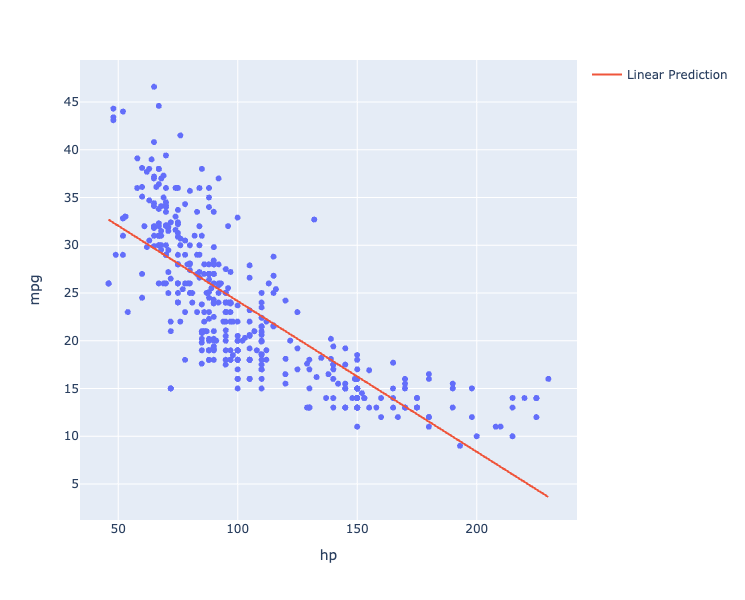

In [428]:
X = vehicles[["hp"]]
y = vehicles["mpg"]

hp_model = LinearRegression()
hp_model.fit(X, y)
hp_model_predictions = hp_model.predict(X)

print(f"MSE of model with (hp) feature: {np.mean((y-hp_model_predictions)**2)}")

fig = px.scatter(vehicles, x="hp", y="mpg", width=800, height=600)
fig.add_trace(go.Scatter(x=vehicles["hp"], y=hp_model_predictions,
                         mode="lines", name="Linear Prediction"))
# sns.scatterplot(data=vehicles, x="hp", y="mpg")
# plt.plot(vehicles["hp"], hp_model_predictions, c="tab:red");



### Polynomial Features

To capture the non-linear relationship between the variables, we can introduce a non-linear feature: `hp` squared. Our new model is:

$$\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2)$$

MSE of model with (hp^2) feature: 18.98476890761725


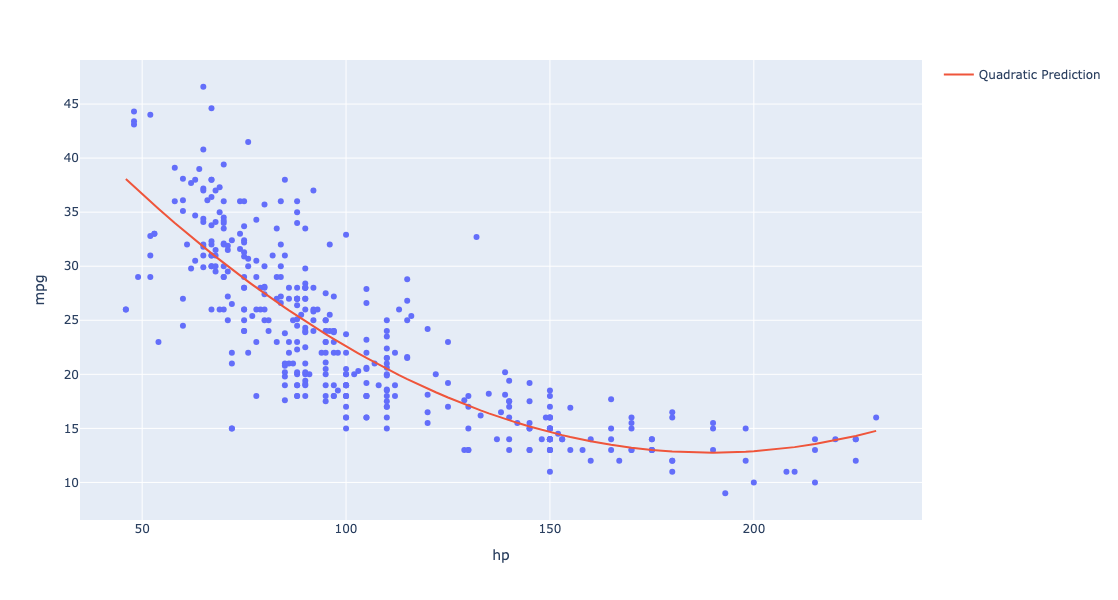

In [10]:
X = vehicles[["hp"]]
X.loc[:, "hp^2"] = vehicles["hp"]**2

hp2_model = LinearRegression()
hp2_model.fit(X, y)
hp2_model_predictions = hp2_model.predict(X)


print(f"MSE of model with (hp^2) feature: {np.mean((y-hp2_model_predictions)**2)}")

fig = px.scatter(vehicles, x="hp", y="mpg", width=800, height=600)
fig.add_trace(go.Scatter(x=vehicles["hp"], y=hp2_model_predictions,
                         mode="lines", name="Quadratic Prediction"))
# sns.scatterplot(data=vehicles, x="hp", y="mpg")
# plt.plot(vehicles["hp"], hp2_model_predictions, c="tab:red");


What if we take things further and add even *more* polynomial features?

The cell below fits models of increasing complexity and computes their MSEs.

In [172]:
def mse(predictions, observations):
    return np.mean((observations - predictions)**2)

# Add hp^3 and hp^4 as features to the data
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4

# Fit a model with order 3
hp3_model = LinearRegression()
hp3_model.fit(X[["hp", "hp^2", "hp^3"]], vehicles["mpg"])
hp3_model_predictions = hp3_model.predict(X[["hp", "hp^2", "hp^3"]])

# Fit a model with order 4
hp4_model = LinearRegression()
hp4_model.fit(X[["hp", "hp^2", "hp^3", "hp^4"]], vehicles["mpg"])
hp4_model_predictions = hp4_model.predict(X[["hp", "hp^2", "hp^3", "hp^4"]])

KeyError: "['hp^2'] not in index"

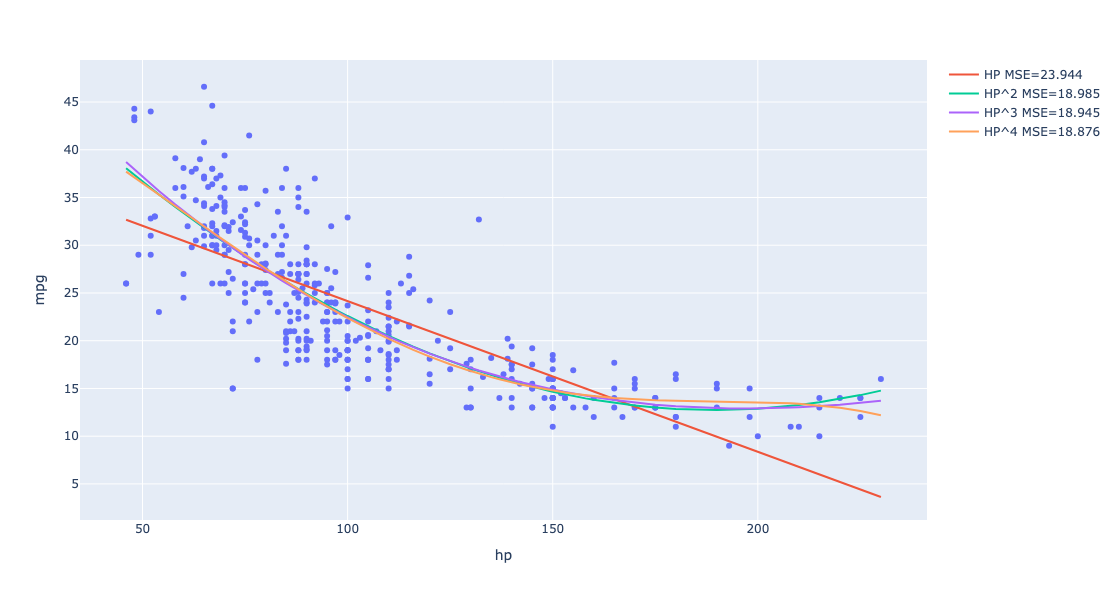

In [7]:
fig = px.scatter(vehicles, x="hp", y="mpg", width=800, height=600)
fig.add_trace(go.Scatter(
    x=vehicles["hp"], y=hp_model_predictions, mode="lines", 
    name=f"HP MSE={np.round(mse(vehicles['mpg'], hp_model_predictions),3)}"))
fig.add_trace(go.Scatter(
    x=vehicles["hp"], y=hp2_model_predictions, mode="lines", 
    name=f"HP^2 MSE={np.round(mse(vehicles['mpg'], hp2_model_predictions),3)}"))
fig.add_trace(go.Scatter(
    x=vehicles["hp"], y=hp3_model_predictions, mode="lines", 
    name=f"HP^3 MSE={np.round(mse(vehicles['mpg'], hp3_model_predictions),3)}"))
fig.add_trace(go.Scatter(
    x=vehicles["hp"], y=hp4_model_predictions, mode="lines", 
    name=f"HP^4 MSE={np.round(mse(vehicles['mpg'], hp4_model_predictions),3)}"))

Visualizing differently:

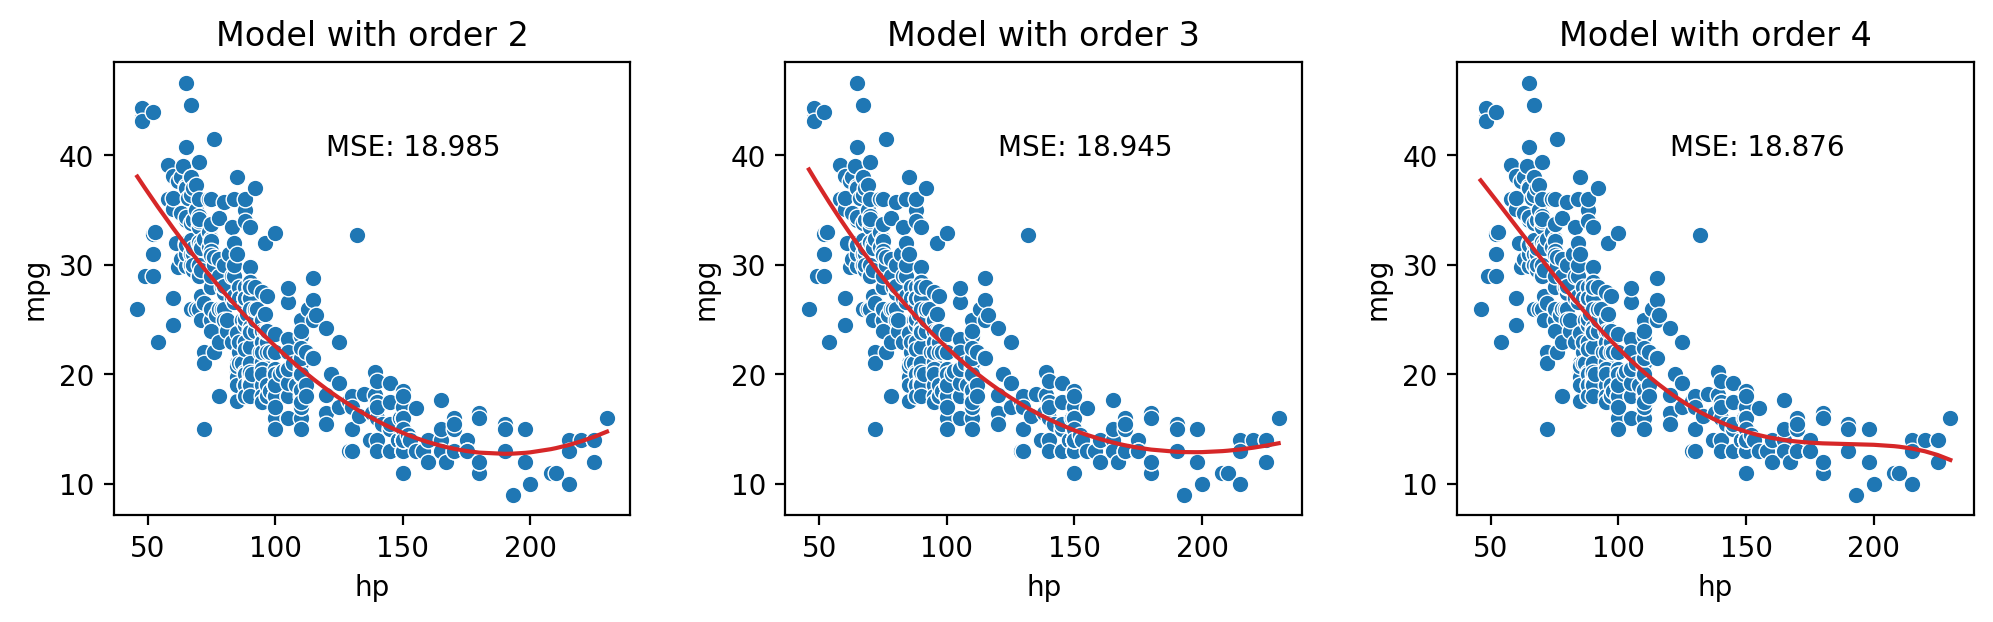

In [174]:
# Plot the models' predictions
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

predictions_dict = {0:hp2_model_predictions, 1:hp3_model_predictions, 2:hp4_model_predictions}

for i in predictions_dict:
    ax[i].scatter(vehicles["hp"], vehicles["mpg"], edgecolor="white", lw=0.5)
    ax[i].plot(vehicles["hp"], predictions_dict[i], "tab:red")
    ax[i].set_title(f"Model with order {i+2}")
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].annotate(f"MSE: {np.round(mse(vehicles['mpg'], predictions_dict[i]), 3)}", (120, 40))

plt.subplots_adjust(wspace=0.3);

## Complexity and Overfitting

What we saw above was the phenomenon of **model complexity** – as we add additional features to the design matrix, the model becomes increasingly *complex*. Models with higher complexity have lower values of training error. Intuitively, this makes sense: with more features at its disposal, the model can match the observations in the trainining data more and more closely. 

We can run an experiment to see this in action. In the cell below, we fit many models of progressively higher complexity, then plot the MSE of predictions on the training set. 

The code used (specifically, the `Pipeline` and `PolynomialFeatures` functions of `sklearn`) is out of scope.

The **order** of a polynomial model is the highest power of any term in the model. An order 0 model takes the form $\hat{y} = \theta_0$, while an order 4 model takes the form $\hat{y} = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \theta_4 x^4$.

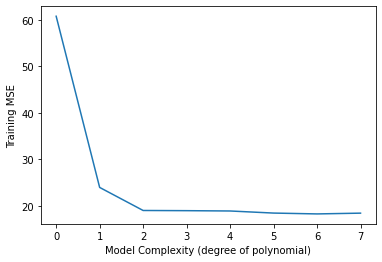

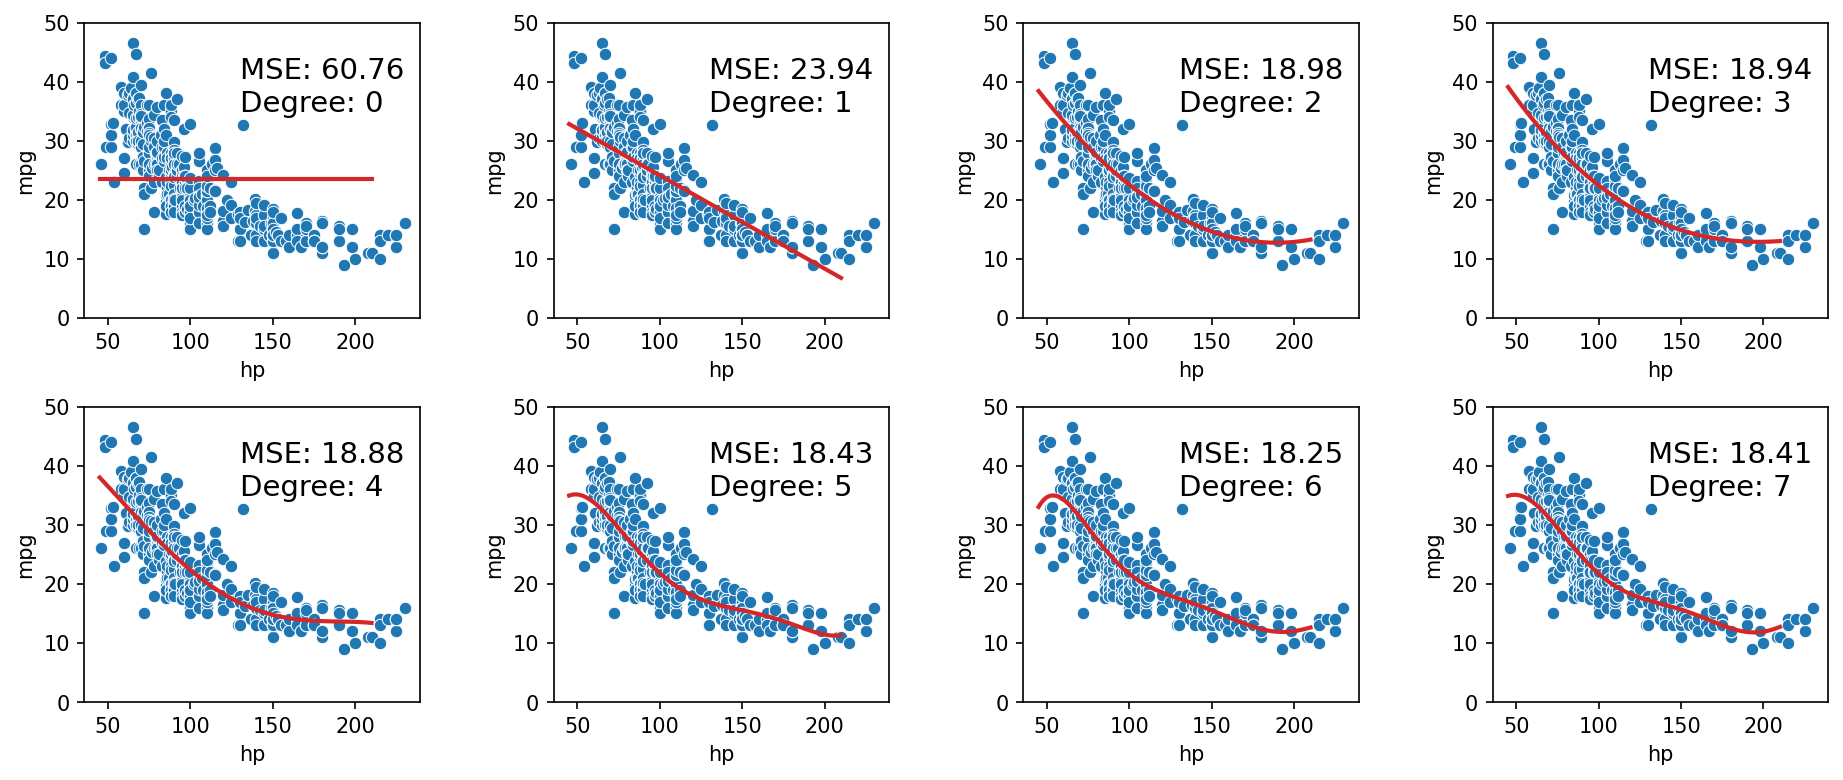

In [176]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree, dataset):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', LinearRegression())    
        ])

    pipelined_model.fit(dataset[["hp"]], dataset["mpg"])
    return mse(dataset['mpg'], pipelined_model.predict(dataset[["hp"]]))

errors = [fit_model_dataset(degree, vehicles) for degree in range(0, 8)]
MSEs_and_k = pd.DataFrame({"k": range(0, 8), "MSE": errors})

plt.plot(range(0, 8), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Training MSE");

def plot_degree_k_model(k, MSEs_and_k, axs):
    pipelined_model = Pipeline([
        ('poly_transform', PolynomialFeatures(degree = k)),
        ('regression', LinearRegression(fit_intercept = True))    
    ])
    pipelined_model.fit(vehicles[["hp"]], vehicles["mpg"])
    
    row = k // 4
    col = k % 4
    ax = axs[row, col]
    
    sns.scatterplot(data=vehicles, x='hp', y='mpg', ax=ax)
    
    x_range = np.linspace(45, 210, 100).reshape(-1, 1)
    ax.plot(x_range, pipelined_model.predict(pd.DataFrame(x_range, columns=['hp'])), c='tab:red', linewidth=2)
    
    ax.set_ylim((0, 50))
    mse_str = f"MSE: {MSEs_and_k.loc[k, 'MSE']:.4}\nDegree: {k}"
    ax.text(130, 35, mse_str, dict(size=14))

fig = plt.figure(figsize=(15, 6), dpi=150)
axs = fig.subplots(nrows=2, ncols=4)

for k in range(8):
    plot_degree_k_model(k, MSEs_and_k, axs)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

As the model increases in polynomial degree (that is, it increases in complexity), the training MSE decreases, plateauing at roughly ~18.

In fact, it is a mathematical fact that if we create a polynomial model with degree $n-1$, we can *perfectly* model a set of $n$ points. For example, a set of 5 points can be perfectly modeled by a degree 4 model.

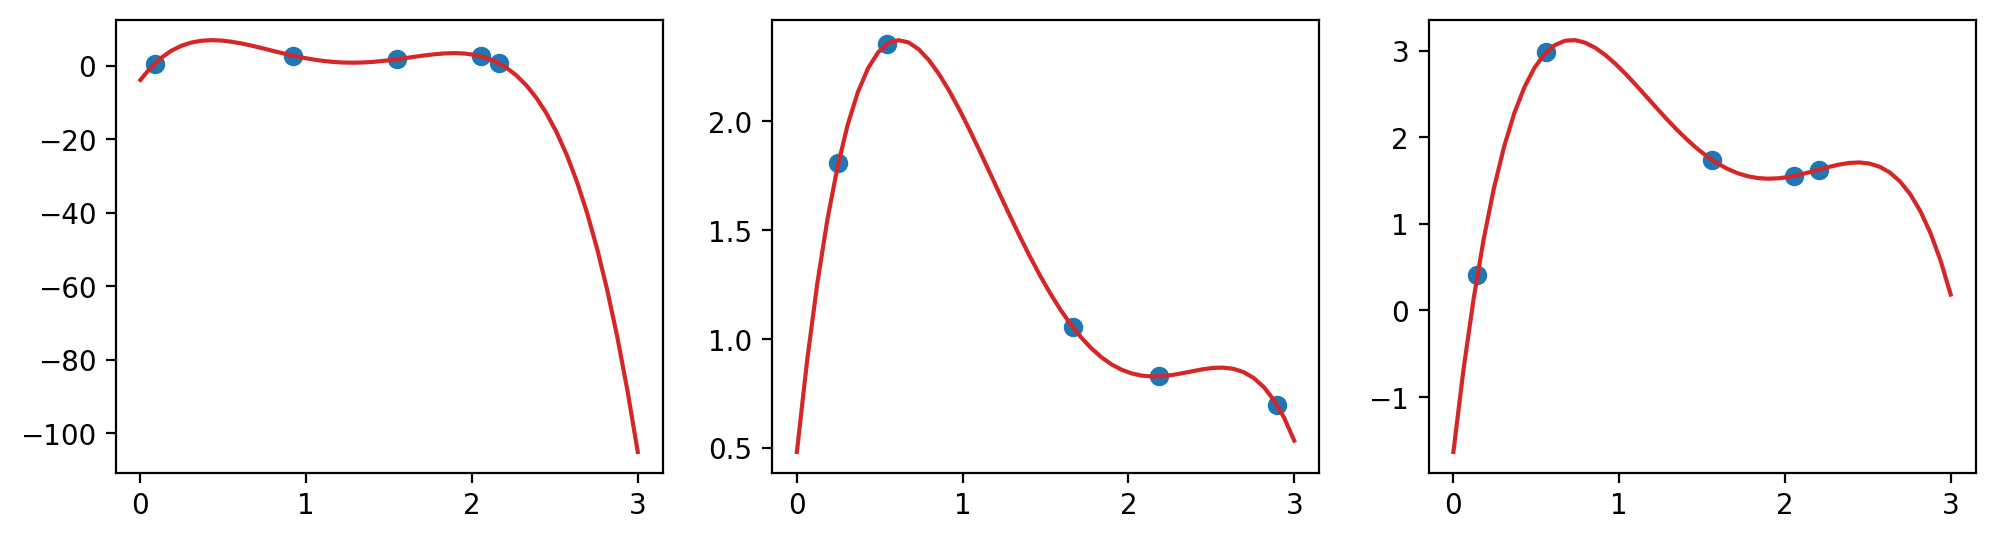

In [178]:
np.random.seed(101)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    points = 3*np.random.uniform(size=(5, 2))

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(4)),
                ('linear_regression', LinearRegression())    
            ])

    polynomial_model.fit(points[:, [0]], points[:, 1])

    ax[i].scatter(points[:, 0], points[:, 1])

    xs = np.linspace(0, 3)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red");

You may be tempted to always design models with high polynomial degree – after all, we know that we could theoretically achieve perfect predictions by creating a model with enough polynomial features. 

It turns out that the examples we looked at above represent a somewhat artificial scenario: we trained our model on all the data we had available, then used the model to make predictions on this very same dataset. A more realistic situation is when we wish to apply our model on unseen data – that is, datapoints that it did not encounter during the model fitting process. 

Suppose we obtain a random sample of 6 datapoints from our population of vehicle data. We want to train a model on these 6 points and use it to make predictions on unseen data (perhaps cars for which we don't already know the true `mpg`). 

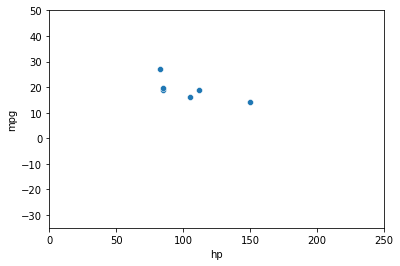

In [180]:
np.random.seed(100)

sample_6 = vehicles.sample(6)

sns.scatterplot(data=sample_6, x="hp", y="mpg")
plt.ylim(-35, 50)
plt.xlim(0, 250);

If we design a model with polynomial degree 5, we can make perfect predictions on this sample of training data.

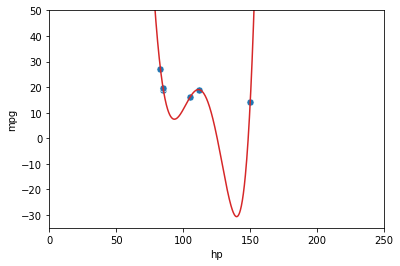

In [182]:
degree_5_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', LinearRegression())    
            ])

degree_5_model.fit(sample_6[["hp"]], sample_6["mpg"])
xs = np.linspace(0, 250, 1000)
degree_5_model_predictions = degree_5_model.predict(xs[:, np.newaxis])

plt.plot(xs, degree_5_model_predictions, c="tab:red")
sns.scatterplot(data=sample_6, x="hp", y="mpg", s=50)
plt.ylim(-35, 50)
plt.xlim(0, 250);

However, when we reapply this fitted model to the full population of data, it fails to capture the major trends of the dataset.

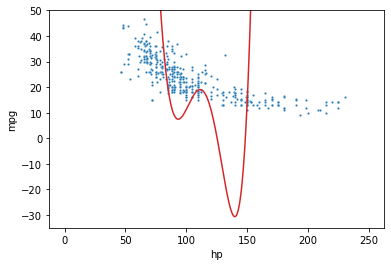

In [184]:
plt.plot(xs, degree_5_model_predictions, c="tab:red")
sns.scatterplot(data=vehicles, x="hp", y="mpg", s=5|0)
plt.ylim(-35, 50);

The model has **overfit** to the data used to train it. It has essentially "memorized" the six datapoints used during model fitting, and does not generalize well to new data. 

Complex models tend to be more sensitive to the data used to train them. The **variance** of a model refers to its tendency to vary depending on the training data used during model fitting. It turns out that our degree-5 model has very high model variance. If we randomly sample new sets of datapoints to use in training, the model varies erratically. 

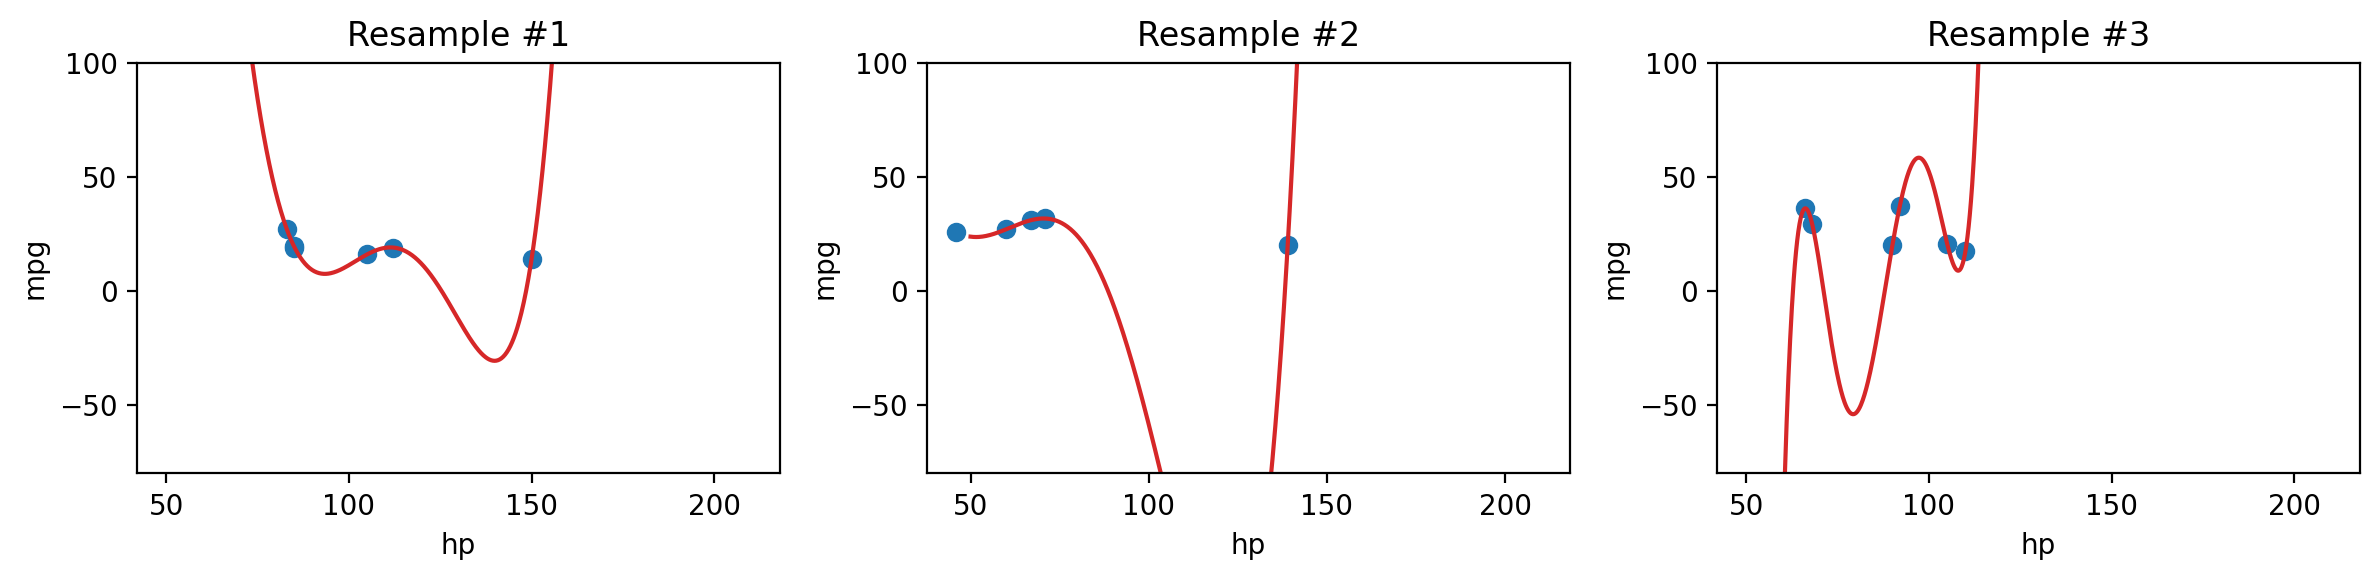

In [186]:
np.random.seed(100)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    sample = vehicles.sample(6)

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', LinearRegression())    
            ])

    polynomial_model.fit(sample[["hp"]], sample["mpg"])

    ax[i].scatter(sample[["hp"]], sample["mpg"])

    xs = np.linspace(50, 210, 1000)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red")
    ax[i].set_ylim(-80, 100)
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].set_title(f"Resample #{i+1}")
    
fig.tight_layout();

Visualizing differently:

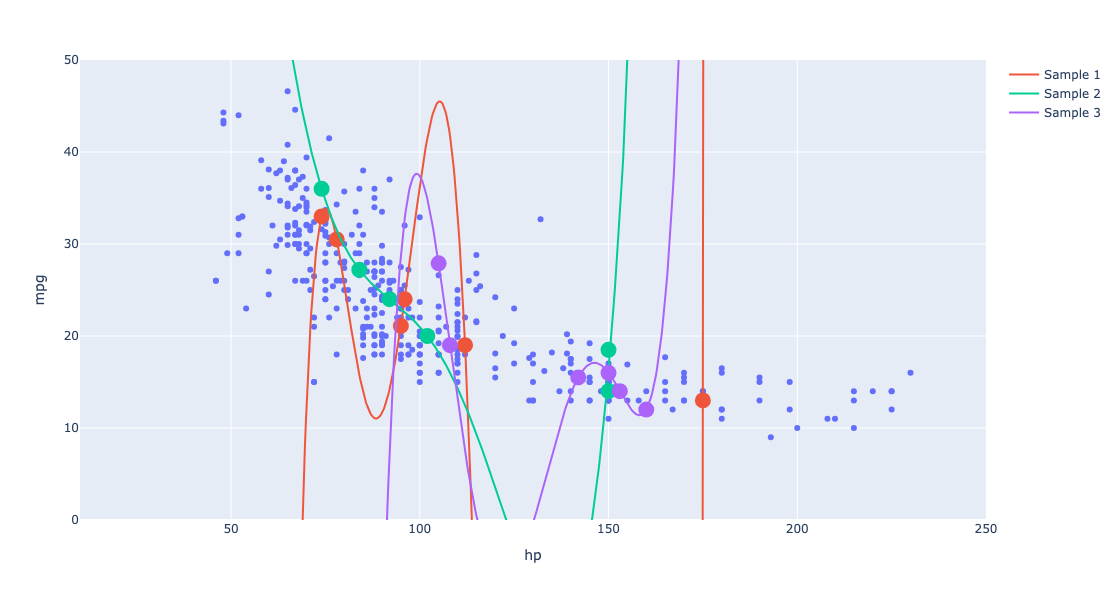

In [15]:
np.random.seed(16)

fig = px.scatter(vehicles, x="hp", y="mpg", width=800, height=600)

for i in range(0, 3):
    sample = vehicles.sample(6).sort_values("hp")
    
    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', LinearRegression())    
            ])

    polynomial_model.fit(sample[["hp"]], sample["mpg"])
    
    name = f"Sample {i+1}"
    fig.add_trace(go.Scatter(x=sample["hp"], y=sample["mpg"], 
        name=name, legendgroup=name, mode="markers", showlegend=False,
        marker_size=16,
        marker_color=px.colors.qualitative.Plotly[i+1]))
    xs = np.linspace(10, 250, 1000)
    fig.add_trace(go.Scatter(x=xs, 
        y=polynomial_model.predict(xs[:, np.newaxis]),
        name=name, legendgroup=name, mode="lines",
        line_color=px.colors.qualitative.Plotly[i+1]))

fig.update_yaxes(range=[0, 50])

# Cross-Validation:

Let's return to the `vehicles` dataset.  

The polynomial degree we use in our model is considered a **hyperparameter** -- it is something we choose before fitting the model.  To pick the best value for the hyperparameter we can use cross validation.

First, let's define our design matrix and the output:

In [188]:
X = vehicles[["hp"]]
X["hp^2"] = vehicles["hp"]**2
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4
X["hp^5"] = vehicles["hp"]**5
X["hp^6"] = vehicles["hp"]**6
X["hp^7"] = vehicles["hp"]**7
X["hp^8"] = vehicles["hp"]**8

Y = vehicles["mpg"]

## Train-Test Split:
The first thing we will want to do with this data is construct a train/test split. Constructing a train test split before EDA and data cleaning can often be helpful.  This allows us to see if our data cleaning and any conclusions we draw from visualizations generalize to new data. This can be done by re-running the data cleaning and EDA process on the test dataset.


### Using Pandas Operations

We can sample the entire dataset to get a permutation and then select a range of rows.

In [39]:
shuffled_data = X.sample(frac=1., random_state=42) #we use random_state here so we all get the same permutation
shuffled_data

,hp,hp^2,hp^3,hp^4,hp^5,hp^6,hp^7,hp^8
46,72.0,5184.0,373248.0,2.687386e+07,1.934918e+09,1.393141e+11,1.003061e+13,7.222041e+14
260,110.0,12100.0,1331000.0,1.464100e+08,1.610510e+10,1.771561e+12,1.948717e+14,2.143589e+16
153,105.0,11025.0,1157625.0,1.215506e+08,1.276282e+10,1.340096e+12,1.407100e+14,1.477455e+16
266,68.0,4624.0,314432.0,2.138138e+07,1.453934e+09,9.886748e+10,6.722989e+12,4.571632e+14
6,220.0,48400.0,10648000.0,2.342560e+09,5.153632e+11,1.133799e+14,2.494358e+16,5.487587e+18
...,...,...,...,...,...,...,...,...
172,71.0,5041.0,357911.0,2.541168e+07,1.804229e+09,1.281003e+11,9.095120e+12,6.457535e+14
240,78.0,6084.0,474552.0,3.701506e+07,2.887174e+09,2.251996e+11,1.756557e+13,1.370114e+15
45,110.0,12100.0,1331000.0,1.464100e+08,1.610510e+10,1.771561e+12,1.948717e+14,2.143589e+16
65,153.0,23409.0,3581577.0,5.479813e+08,8.384114e+10,1.282769e+13,1.962637e+15,3.002835e+17


Selecting a range of rows for training and test

In [41]:
split_point = int(shuffled_data.shape[0]*0.80)
split_point

313

In [43]:
tr = shuffled_data.iloc[:split_point]
te = shuffled_data.iloc[split_point:]

In [45]:
tr.head()

,hp,hp^2,hp^3,hp^4,hp^5,hp^6,hp^7,hp^8
46,72.0,5184.0,373248.0,2.687386e+07,1.934918e+09,1.393141e+11,1.003061e+13,7.222041e+14
260,110.0,12100.0,1331000.0,1.464100e+08,1.610510e+10,1.771561e+12,1.948717e+14,2.143589e+16
153,105.0,11025.0,1157625.0,1.215506e+08,1.276282e+10,1.340096e+12,1.407100e+14,1.477455e+16
266,68.0,4624.0,314432.0,2.138138e+07,1.453934e+09,9.886748e+10,6.722989e+12,4.571632e+14
6,220.0,48400.0,10648000.0,2.342560e+09,5.153632e+11,1.133799e+14,2.494358e+16,5.487587e+18


In [47]:
te.head()

,hp,hp^2,hp^3,hp^4,hp^5,hp^6,hp^7,hp^8
125,95.0,9025.0,857375.0,81450625.0,7.737809e+09,7.350919e+11,6.983373e+13,6.634204e+15
171,96.0,9216.0,884736.0,84934656.0,8.153727e+09,7.827578e+11,7.514475e+13,7.213896e+15
286,129.0,16641.0,2146689.0,276922881.0,3.572305e+10,4.608274e+12,5.944673e+14,7.668628e+16
263,165.0,27225.0,4492125.0,741200625.0,1.222981e+11,2.017919e+13,3.329566e+15,5.493784e+17
258,105.0,11025.0,1157625.0,121550625.0,1.276282e+10,1.340096e+12,1.407100e+14,1.477455e+16


Checking that they add up.

In [49]:
len(tr) + len(te) == len(X)

True

### Using SKLearn

We can use the `train_test_split` function from `sklearn.model_selection` to do this easily.

In [190]:
from sklearn.model_selection import train_test_split

# `test_size` specifies the proportion of the full dataset that should be allocated to testing.
# `random_state` makes our results reproducible for educational purposes.
# shuffle is True by default and randomizes the data before splitting.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=100, 
                                                    shuffle=True)

print(f"Size of full dataset: {X.shape[0]} points")
print(f"Size of training set: {X_train.shape[0]} points")
print(f"Size of test set: {X_test.shape[0]} points")

Size of full dataset: 392 points
Size of training set: 313 points
Size of test set: 79 points


We then fit the model using the training set...

In [194]:
import sklearn.linear_model as lm

model = lm.LinearRegression()

model.fit(X_train, Y_train)

LinearRegression()

...and evaluate its performance by making predictions on the test set. Notice that the model performs more poorly on the test data it did not encounter during training.

In [196]:
from sklearn.metrics import mean_squared_error

train_error = mean_squared_error(Y_train, model.predict(X_train))
test_error = mean_squared_error(Y_test, model.predict(X_test))

print(f"Training error: {train_error}")
print(f"Test error: {test_error}")

Training error: 18.11983711505113
Test error: 20.808612397810396


## Validation Sets

To assess model performance on unseen data, then *use* this information to finetune the model, we introduce a validation set. You can imagine this as us splitting the training set into a validation set and a "mini" training set.

In [198]:
# Split X_train further into X_train_mini and X_val.
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=100)

print(f"Size of original training set: {X_train.shape[0]} points")
print(f"Size of mini training set: {X_train_mini.shape[0]} points")
print(f"Size of validation set: {X_val.shape[0]} points")

Size of original training set: 313 points
Size of mini training set: 250 points
Size of validation set: 63 points


In the cell below, we repeat the experiment from above: fit several models of increasing complexity, then compute their errors. Here, we find the model's errors on the **validation set** to understand how model complexity influences performance on unseen data.

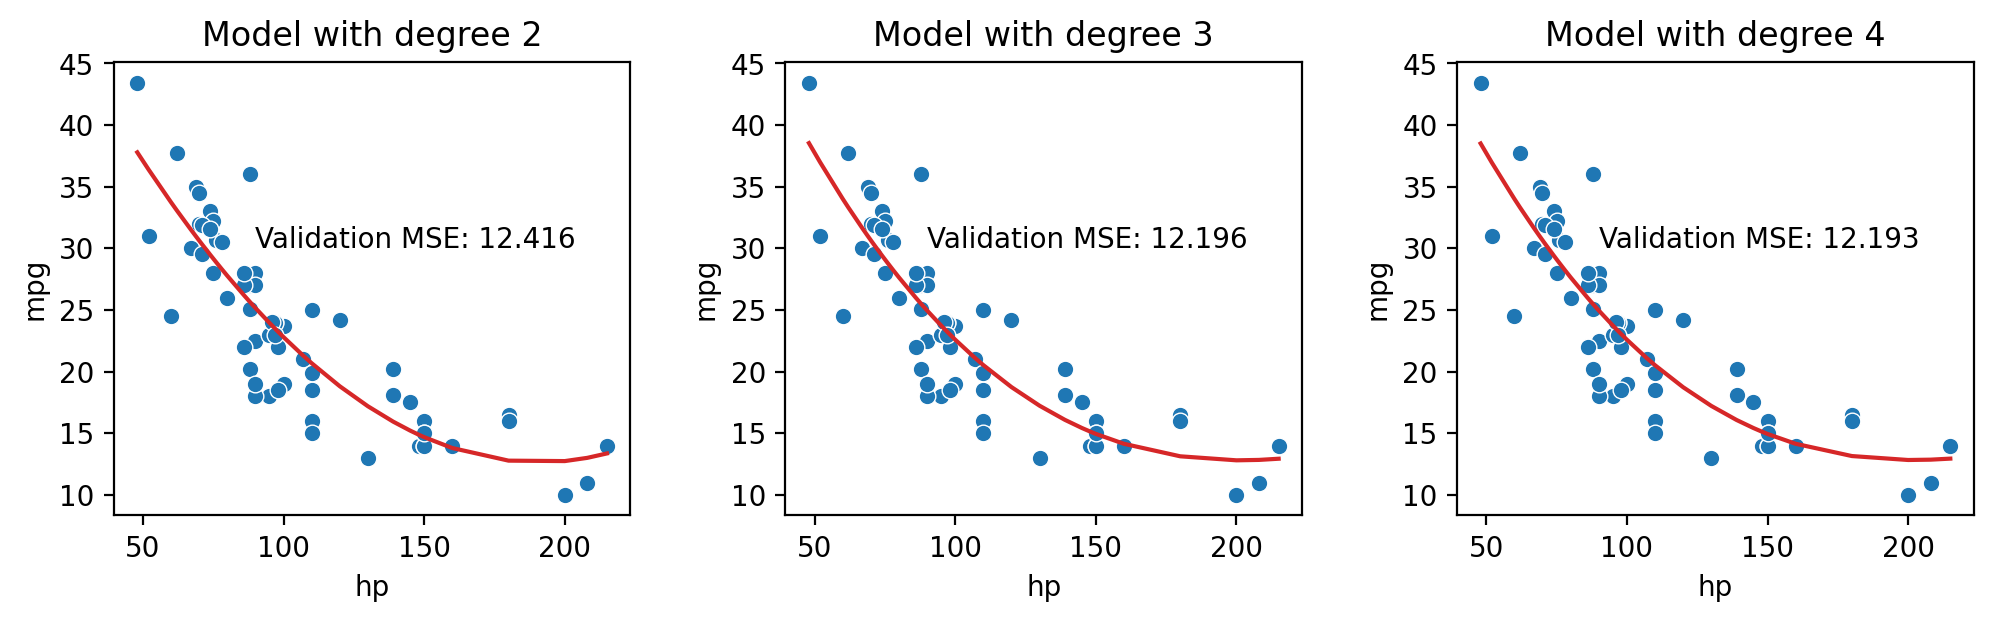

In [200]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for order in [2, 3, 4]:
    model = lm.LinearRegression()
    model.fit(X_train_mini.iloc[:, :order], Y_train_mini)
    val_predictions = model.predict(X_val.iloc[:, :order])
    
    output = X_val.iloc[:, :order]
    output["y_hat"] = val_predictions
    output = output.sort_values("hp")
    
    ax[order-2].scatter(X_val["hp"], Y_val, edgecolor="white", lw=0.5)
    ax[order-2].plot(output["hp"], output["y_hat"], "tab:red")
    ax[order-2].set_title(f"Model with degree {order}")
    ax[order-2].set_xlabel("hp")
    ax[order-2].set_ylabel("mpg")
    ax[order-2].annotate(f"Validation MSE: {np.round(mean_squared_error(Y_val, val_predictions), 3)}", (90, 30))

plt.subplots_adjust(wspace=0.3);

Let's repeat this process:

1. Fit an degree-x model to the mini training set
2. Evaluate the fitted model's MSE when making predictions on the validation set

We use the model's performance on the validation set as a guide to selecting the best combination of features. We are not limited in the number of times we use the validation set – we just never use this set to fit the model.

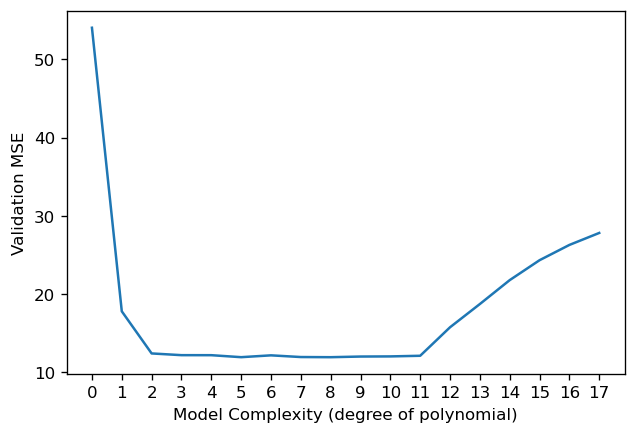

In [202]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())    
        ])

    pipelined_model.fit(X_train_mini[["hp"]], Y_train_mini)
    return mean_squared_error(Y_val, pipelined_model.predict(X_val[["hp"]]))

errors = [fit_model_dataset(degree) for degree in range(0, 18)]
MSEs_and_k = pd.DataFrame({"k": range(0, 18), "MSE": errors})

plt.figure(dpi=120)
plt.plot(range(0, 18), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Validation MSE")
plt.xticks(range(0, 18));

In [46]:
MSEs_and_k.rename(columns={"k":"Degree"}).set_index("Degree")

,MSE
Degree,
0,54.024495
1,17.798108
2,12.415902
3,12.196206
4,12.192597
5,11.938305
6,12.167245
7,11.955930
8,11.936336


From this **model selection** process (using the Holdout Cross-Validation method), we might choose to create a model with degree 8.

In [204]:
print(f'Polynomial degree with lowest validation error: {MSEs_and_k.sort_values("MSE").head(1)["k"].values}')

Polynomial degree with lowest validation error: [8]


Thus, using validation for model selection, we have decided on the following model as the "best":
$$y=\theta_0+\theta_1(hp)+\theta_2(hp^2)+\theta_3(hp^3)+\theta_4(hp^4)+\theta_5(hp^5)+\theta_6(hp^6)+\theta_7(hp^7)+\theta_8(hp^8)$$

After this choice has been finalized, and we are completely finished with the model design process, we finally assess model performance on the test set. We typically use the entire training set (both the "mini" training set and validation set) to fit the final model.

In [238]:
# Update our training and test sets to include all polynomial features between 5 and 8
for degree in range(5, 9):
    X_train[f"hp^{degree}"] = X_train["hp"]**degree
    X_test[f"hp^{degree}"] = X_test["hp"]**degree

final_model = lm.LinearRegression()
final_model.fit(X_train, Y_train)

pd.DataFrame({"Feature":X_train.columns, "Model Coefficient":final_model.coef_}).set_index("Feature")  


,Model Coefficient
Feature,
hp,-2.379214e-08
hp^2,-1.599224e-06
hp^3,-4.487180e-05
hp^4,-5.521331e-07
hp^5,1.867569e-08
hp^6,-1.522607e-10
hp^7,5.191884e-13
hp^8,-6.505304e-16


Visualization of final model and the test data set:

Test MSE of final (8th order) model: 20.808612397810396


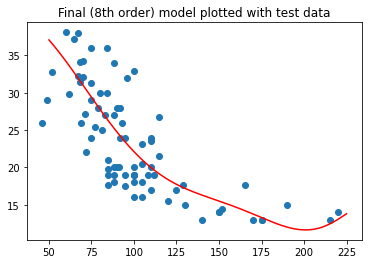

In [346]:
plt.scatter(X_test["hp"].values, Y_test.values)

x_vals = np.linspace(50, 225, 175)
X_vals = pd.DataFrame({"hp":x_vals, "hp^2":x_vals**2, "hp^3":x_vals**3, "hp^4":x_vals**4, "hp^5":x_vals**5, "hp^6":x_vals**6, "hp^7":x_vals**7, "hp^8":x_vals**8})


plt.plot(x_vals, final_model.predict(X_vals), color = 'red');
plt.title("Final (8th order) model plotted with test data")

print(f"Test MSE of final (8th order) model: {mean_squared_error(Y_test, final_model.predict(X_test))}")

## k-fold Cross-Validation

The validation set gave us an opportunity to understand how the model performs on a **single** set of unseen data. The specific validation set we drew was fixed – we used the same validation points every time.

It's possible that we may have, by random chance, selected a set of validation points that was *not* representative of other unseen data that the model might encounter (for example, if we happened to have selected all outlying data points for the validation set).

Different train/validation splits lead to different validation errors:

In [65]:
#try 3 different train/validation splits and see their errors:
for i in range(1, 4):
    X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
    model = lm.LinearRegression()
    model.fit(X_train_mini, Y_train_mini)
    y_hat = model.predict(X_val)
    print(f"Val error from train/validation split #{i}: {mean_squared_error(y_hat, Y_val)}")

Val error from train/validation split #1: 19.033175951855995
Val error from train/validation split #2: 16.415755513831684
Val error from train/validation split #3: 24.4487697448043


<br/><br/><br/>


---


## Using k-fold cross validation for hyperparameter selection:

To account for the variation in the validation sets that we saw above, let's see what the 5-fold Cross-validation MSE is for a model with an 8 degree polynomial.




In the following function we use the sklearn `KFold` cross validation class. 


Here we define a five fold cross validation with 

```python 
five_fold = KFold(n_splits=5)
```

Then we loop over the 5 splits and get the indicies (`tr_ind`) in the training data to use for training and the indices (`va_ind`) in the training data to use for validation:

```python
for tr_ind, te_ind in five_fold.split(tr):
```

In [165]:
from sklearn.model_selection import KFold
np.random.seed(25) # Ensures reproducibility of this notebook

# n_splits sets the number of folds to create
five_fold = KFold(n_splits=5, shuffle=True)
validation_errors = []

for train_idx, valid_idx in five_fold.split(X_train):
    # Split the data
    split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

    # Fit the model on the training split
    model.fit(split_X_train, split_Y_train)

    error = mean_squared_error(model.predict(split_X_valid), split_Y_valid)

    validation_errors.append(error)

print("validation errors for each fold:", validation_errors)

print(f"Cross-validation error for degree 8 polynomial: {np.mean(validation_errors)}")

validation errors for each fold: [22.8282018769396, 20.673924455015822, 13.073170690787215, 16.20817117212132, 15.314742875844026]
Cross-validation error for degree 8 polynomial: 17.619642214141596


Let's use 5-fold cross validation to choose the best degree polynomial.  We may end up with the same conclusion (order 8) as above, but if not, we will choose what we get from 5-fold validation as it accounts for possible unrepresentative patterns in our validation set above.  The code below calculates the 5-fold cross validation error for models of degree 2 through 10:

In [72]:
from sklearn.model_selection import KFold
np.random.seed(25)

def train_with_crossvalidation(degree, folds):
    
    # n_splits sets the number of folds to create
    
    kf = KFold(n_splits=folds, shuffle=True)
    validation_errors = []

    X = X_train[["hp"]]
    Y = Y_train
    
    model = Pipeline([
        ('transform', PolynomialFeatures(degree = degree)),
        ('regression', LinearRegression(fit_intercept = True))    
    ])
    for train_idx, valid_idx in kf.split(X):
        # Split the data
        split_X_train, split_X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y.iloc[train_idx], Y.iloc[valid_idx]
      
        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        error = mse(model.predict(split_X_valid), split_Y_valid)

        validation_errors.append(error)
    return np.mean(validation_errors)

In [83]:
np.random.seed(25)
# Choose the order of polynomials to test
ks = np.array(range(0, 11))
folds = np.array([5])
MSEs_CV = pd.DataFrame(columns = ['k', 'folds', 'Ave MSE'])

for k in ks:
    for f in folds:
        
        MSEs_CV.loc[len(MSEs_CV)] = {'k': k, 'folds': f, 'Ave MSE': train_with_crossvalidation(k, f)} 


MSEs_CV['k'] = MSEs_CV['k'].astype('int')
MSEs_CV['folds'] = MSEs_CV['folds'].astype('int')

MSEs_CV

,k,folds,Ave MSE
0,0,5,63.958468
1,1,5,23.924576
2,2,5,18.897475
3,3,5,18.741573
4,4,5,19.182630
5,5,5,18.377898
6,6,5,19.177873
7,7,5,18.890887
8,8,5,18.856962
9,9,5,18.859038


In [79]:
print(f'Polynomial degree with lowest 5-fold cross validation error: {MSEs_CV.sort_values("Ave MSE").head(1)["k"].values}')

Polynomial degree with lowest 5-fold cross validation error: [5]


Thus, using 5-fold cross validation for model selection, we have decided on the following model as the "best":
$$y=\theta_0+\theta_1(hp)+\theta_2(hp^2)+\theta_3(hp^3)+\theta_4(hp^4)+\theta_5(hp^5)$$

Conclusion: Using 5-fold cross validation we would choose a 5th order model

## After Model Selection, use the mini training and validation set together to fit the final model (i.e. solve for the best theta values): 
 

After this choice has been finalized, and we are completely finished with the model design process, we finally assess model performance on the test set. We typically use the entire training set (both the "mini" training set and validation set) to fit the final model.

In [508]:
# Once we've used cross-validation to determine the highest order of the polynomial, 
# we can create our FINAL model using all of the training data

# Update our training and test sets to include all polynomial features up to order 5:


X_train = X_train.drop(columns = ["hp^6","hp^7","hp^8"])
X_test = X_test.drop(columns = ["hp^6","hp^7","hp^8"])




KeyError: "['hp^6', 'hp^7', 'hp^8'] not found in axis"

## Use the test data set (ONCE), to get your FINAL result
After this choice has been finalized, and we are completely finished with the model design process, we finally assess model performance (ONCE) on the test set.

In [368]:
final_model_kfold = lm.LinearRegression()
final_model_kfold.fit(X_train, Y_train)

pd.DataFrame({"Feature":X_train.columns, "Model Coefficient":final_model_kfold.coef_}).set_index("Feature")  


,Model Coefficient
Feature,
hp,2.480553e+00
hp^2,-5.187706e-02
hp^3,4.443295e-04
hp^4,-1.741150e-06
hp^5,2.577563e-09


Test MSE of final (5th order) model: 20.376337122963143


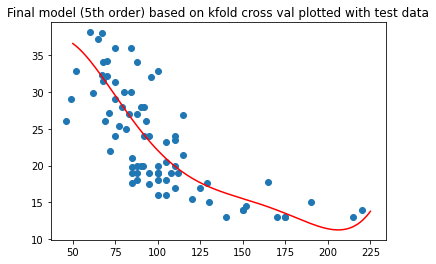

In [386]:
plt.scatter(X_test["hp"].values, Y_test.values)

x_vals = np.linspace(50, 225, 175)
X_vals = pd.DataFrame({"hp":x_vals, "hp^2":x_vals**2, "hp^3":x_vals**3, "hp^4":x_vals**4, "hp^5":x_vals**5})


plt.plot(x_vals, final_model_kfold.predict(X_vals), color = 'red');
plt.title("Final model (5th order) based on kfold cross val plotted with test data")

print(f"Test MSE of final (5th order) model: {mean_squared_error(Y_test, final_model_kfold.predict(X_test))}")

# II) Adding More Features



Let's go through the process of adding more features to our model. 

We'll start with the model from above (using hp up to power hp^5) and then add engine characteristics like "cylinders" and the "displacement". 

For efficiency will use `sklearn` `Pipelines` to combine feature functions and models.  
For CSPB 3022, you **do not** need to know how to use `Pipeline`s in scikit-learn. They are quite involved. Fortunately, they are merely an accessory to the concepts of this lecture, and not the core of it. If you treat each instance of a `Pipeline` as a black-box way of specifying which features our model should have, you will be able to understand the cross-validation content just fine.




As we will see, by combining the feature function and model, we can simplify subsequent training and testing since we are guaranteed that our feature functions are the same on both the training and test datasets. 

In [506]:
vehicles = sns.load_dataset("mpg").dropna().rename(columns = {"horsepower": "hp"}).sort_values("hp")
vehicles.head()

,mpg,cylinders,displacement,hp,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


In [390]:
from sklearn.model_selection import train_test_split

# `test_size` specifies the proportion of the full dataset that should be allocated to testing.
# `random_state` makes our results reproducible for educational purposes.
# shuffle is True by default and randomizes the data before splitting.


X = vehicles.drop(columns = ["mpg"])
Y= vehicles["mpg"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=100, 
                                                    shuffle=True)

print(f"Size of full dataset: {X.shape[0]} points")
print(f"Size of training set: {X_train.shape[0]} points")
print(f"Size of test set: {X_test.shape[0]} points")

Size of full dataset: 392 points
Size of training set: 313 points
Size of test set: 79 points


In [392]:
# Split X_train further into X_train_mini and X_val.
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=100)

print(f"Size of original training set: {X_train.shape[0]} points")
print(f"Size of mini training set: {X_train_mini.shape[0]} points")
print(f"Size of validation set: {X_val.shape[0]} points")

Size of original training set: 313 points
Size of mini training set: 250 points
Size of validation set: 63 points


In [394]:
X_train_mini.head()

,cylinders,displacement,hp,weight,acceleration,model_year,origin,name
324,4,85.0,65.0,2110,19.2,80,japan,datsun 210
187,8,305.0,140.0,4215,13.0,76,usa,chevrolet chevelle malibu classic
397,4,119.0,82.0,2720,19.4,82,usa,chevy s-10
284,6,225.0,110.0,3360,16.6,79,usa,dodge aspen 6
181,4,91.0,53.0,1795,17.5,75,japan,honda civic cvcc


In [396]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

<br/><br/><br/>

---

## SKLearn Pipelines

Again, for CSPB 3022, you do not need to know how to use `Pipeline`s in scikit-learn. They are quite involved. Fortunately, they are merely an accessory to the concepts of this lecture, and not the core of it. If you treat each instance of a `Pipeline` as a black-box way of specifying which features our model should have, you will be able to understand the cross-validation content just fine.

We have removed much of the dialogue around `Pipeline` from this lecture, but if you're interested, you can [skim the documentation on pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline).

In [478]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

model = Pipeline([
    ("SelectColumns", ColumnTransformer([("keep", "passthrough", ["hp"])])),
    ("LinearModel", LinearRegression())
])

model.fit(X_train, Y_train);

#### Keeping track of all the models.

In this notebook (and in life) we will want to keep track of all our models.  Here I will store the models in a dictionary with a (not great) name so I can remember which model is which and can easily compare my models in a plot.

In [480]:
models = {"hp": model}

### More Feature Transformations
As we saw above, we may want to use horsepower up to the 5th power.  We'll start with adding up to **hp^2**.  This is an additional feature transformation that we can add to the first stage of our pipeline.  To define this transformation we first need to create a function transformer:


In [482]:
from sklearn.preprocessing import FunctionTransformer

def compute_square(X):
    return np.expand_dims(X[:,0]**2  , axis=1)

square_transformer = FunctionTransformer(compute_square, validate=True)

We can then add this as an additional column transformation:

In [510]:
model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", ["hp"]),
        ("hp^2", square_transformer, ["hp"])])),
    ("LinearModel", LinearRegression())
])

In [512]:
model.fit(X_train, Y_train);

Again, we evaluate the model on our training dataset to see the error:

In [514]:
Y_hat = model.predict(X_train)
Y = Y_train
print("Training Error (MSE):", mse(Y, Y_hat))

Training Error (MSE): 18.444466031515855


In [516]:
models["hp+hp2"] = model

**Adding up to 5th degree of hp**

In [518]:
def compute_cube(X):
    return np.expand_dims(X[:,0]**3  , axis=1)

cube_transformer = FunctionTransformer(compute_cube, validate=True)

In [520]:
def compute_4th(X):
    return np.expand_dims(X[:,0]**4  , axis=1)

fourth_transformer = FunctionTransformer(compute_4th, validate=True)

In [522]:
def compute_5th(X):
    return np.expand_dims(X[:,0]**5  , axis=1)

fifth_transformer = FunctionTransformer(compute_5th, validate=True)

In [524]:
model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", ["hp"]),
        ("hp^2", square_transformer, ["hp"]),
        ("hp^3", cube_transformer, ["hp"]),
        ("hp^4", fourth_transformer, ["hp"]),
        ("hp^5", fifth_transformer, ["hp"])])),
    ("LinearModel", LinearRegression())
])

In [526]:
model.fit(X_train, Y_train);

In [528]:
Y_hat = model.predict(X_train)
Y = Y_train
print("Training Error (MSE):", mse(Y, Y_hat))

Training Error (MSE): 18.064691279083245


In [530]:
models["hp..hp5"] = model

### Adding More Features

We might also want to add cylinders and displacement.   

We can then add these as additional column transformation:

In [540]:
model = Pipeline([
    ("SelectColumns", ColumnTransformer([("keep", "passthrough", ["cylinders", "displacement", "hp"]),
        ("hp^2", square_transformer, ["hp"]),
        ("hp^3", cube_transformer, ["hp"]),
        ("hp^4", fourth_transformer, ["hp"]),
        ("hp^5", fifth_transformer, ["hp"])])),
    ("LinearModel", LinearRegression())
])

In [542]:
model.fit(X_train, Y_train);

Again, we evaluate the model on our training dataset but notice we see our error slightly increases:

In [544]:
Y_hat = model.predict(X_train)
Y = Y_train
print("Training Error (MSE):", mse(Y, Y_hat))

Training Error (MSE): 15.666901417201828


In [546]:
models["hp..hp5+c+d"] = model

### More Feature Transformations

We might also want to look at the **displacement per cylinder**.  This is an additional feature transformation that we can add to the first stage of our pipeline.  To define this transformation we first need to create a function transformer:

In [548]:
def compute_volume(X):
    return np.expand_dims(X[:,1] / X[:,0]  , axis=1)

volume_transformer = FunctionTransformer(compute_volume, validate=True)

In [550]:
model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", ["cylinders", "displacement", "hp"]),
        ("hp^2", square_transformer, ["hp"]),
        ("hp^3", cube_transformer, ["hp"]),
        ("hp^4", fourth_transformer, ["hp"]),
        ("hp^5", fifth_transformer, ["hp"]),
        ("cyl_vol", volume_transformer, ["cylinders", "displacement"])])),
    ("LinearModel", LinearRegression())
])

In [552]:
model.fit(X_train, Y_train);

Again, we evaluate the model on our training dataset and see a reduction in error:

In [556]:
Y_hat = model.predict(X_train)
Y = Y_train
print("Training Error (MSE):", mse(Y, Y_hat))

Training Error (MSE): 15.542343583553539


In [146]:
models["hp..hp5+c+d+d/c"] = model

### Adding More Features

We can now add additional features about the car.

In [558]:
quantitative_features = ["cylinders", "displacement","hp" ,"weight", "acceleration"]
model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", quantitative_features),
        ("hp^2", square_transformer, ["hp"]),
        ("hp^3", cube_transformer, ["hp"]),
        ("hp^4", fourth_transformer, ["hp"]),
        ("hp^5", fifth_transformer, ["hp"]),
        ("cyl_vol", volume_transformer, ["cylinders", "displacement"])])),
    ("LinearModel", LinearRegression())
])

## Dealing with NaN data

If there are NaN (missing values) in the data we will need to deal with these missing values.  In previous lectures I mentioned imputation and a standard imputation technique is to replace the missing value with the mean for that column.  Scikit learn has a built-in imputation function that we can add to our pipeline after we select the desired columns.  The imputation will actually be applied to all the columns.  If we wanted to apply it to a specific column then we would need to put it inside the ColumnTransformer.

**Notice:** The imputation function actually needs to be **fit** to data so it is also part of the model.

In [560]:
from sklearn.impute import SimpleImputer
model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", quantitative_features),
        ("hp^2", square_transformer, ["hp"]),
        ("hp^3", cube_transformer, ["hp"]),
        ("hp^4", fourth_transformer, ["hp"]),
        ("hp^5", fifth_transformer, ["hp"]),
        ("cyl_vol", volume_transformer, ["cylinders", "displacement"])])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", LinearRegression())
])

We can now train our model.

In [562]:
quantitative_features = ["cylinders", "displacement", "hp", "weight", "acceleration"]

In [564]:
model.fit(X_train, Y_train);

Saving the model for later comparison:

In [566]:
models['hp..hp5+c+d+d/c+w+a'] = model

Evaluating the training error:

In [570]:
Y_hat = model.predict(X_train)
Y = Y_train
print("Training Error (MSE):", mse(Y, Y_hat))

Training Error (MSE): 14.642289967068548


We reduced the training error but what about the test error?  We really shouldn't look at the test error so instead we will use cross validation to compare the accuracy:

<br/><br/><br/>

---

## Cross Validation

In the following function we use the sklearn `KFold` cross validation class. 

Here we define a five fold cross validation with 

```python 
five_fold = KFold(n_splits=5)
```

Then we loop over the 5 splits and get the indicies (`tr_ind`) in the training data to use for training and the indices (`va_ind`) in the training data to use for validation:

```python
for tr_ind, te_ind in five_fold.split(tr):
```

In [627]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_mse(model):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    mse_values = []
    for tr_ind, va_ind in five_fold.split(X_train):
        model.fit(X_train.iloc[tr_ind,:], Y_train.iloc[tr_ind])
        mse_values.append(mse(Y_train.iloc[va_ind], model.predict(X_train.iloc[va_ind,:])))
    return np.mean(mse_values)


Valiating the model

In [588]:
cross_validate_mse(model)

17.268043598961917

The following helper function generates a plot comparing all the models in the models dictionary.

In [590]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff


In [596]:


def compare_models(models):
    # Compute the training error for each model
    training_mse = [mse(Y_train, model.predict(X_train)) for model in models.values()]
    # Compute the cross validation error for each model
    validation_mse = [cross_validate_mse(model) for model in models.values()]
    # Compute the test error for each model (don't do this!)
    test_mse = [mse(Y_test, model.predict(X_test)) for model in models.values()]
    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_mse, name="Training MSE"),
        go.Bar(x = names, y = validation_mse, name="CV MSE"),
        go.Bar(x = names, y = test_mse, name="Test MSE", opacity=.3)])
    return fig

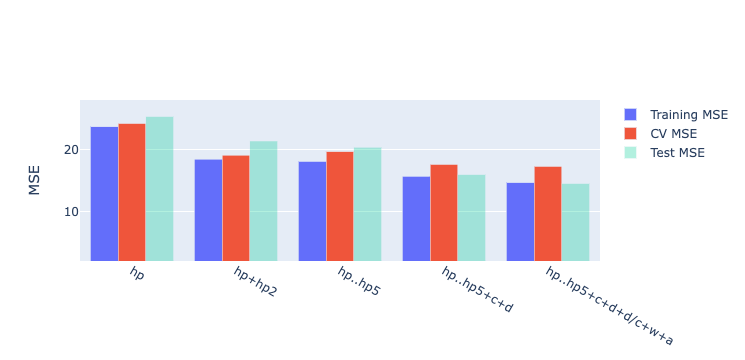

In [604]:
fig = compare_models(models)
fig.update_yaxes(range=[2,28], title="MSE")

Notice I made the **Test MSE** invisible(ish) because you shouldn't look at it until we are done.  But again for demonstration purposes I plotted in so we can see how it compares to the training and cross validation errors.

Can you improve the model further?  Let's try adding the model year

In [607]:
quantitative_features = ["cylinders", "displacement", "hp", "weight", "acceleration", "model_year"]
model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", quantitative_features),
        ("hp^2", square_transformer, ["hp"]),
        ("hp^3", cube_transformer, ["hp"]),
        ("hp^4", fourth_transformer, ["hp"]),
        ("hp^5", fifth_transformer, ["hp"]),
        ("cyl_vol", volume_transformer, ["cylinders", "displacement"])])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", LinearRegression())
])

In [609]:

model.fit(X_train, Y_train)
models['h..hp^5+c+d+d/c+w+a+y'] = model

Comparing the models

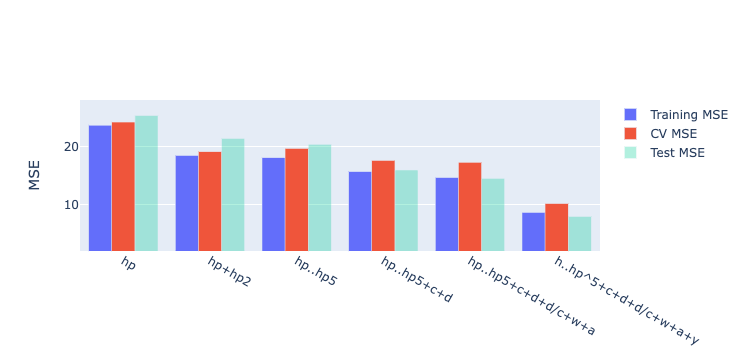

In [613]:
fig = compare_models(models)
fig.update_yaxes(range=[2,28], title="MSE")

The model year improved accuracy quite a bit!  This improvement also appears to generalize as it also reduced the cross validation error. 

## Going too Far?

Can we use the **car's name** to predict MPG?  The name contains general features like the manufacturer that might help but it also contains the vehicle make which is probably too specific and not all the vehicles in test will appear in training. 

Let's try by applying the CountVectorizer (which implements something called a "Bag of Words"  (https://www.mygreatlearning.com/blog/bag-of-words/).  At this point we are also likely to have too many dimensions in our model and we are not applying any regularization technique to compensate (because we haven't covered regularization in lecture yet.)

In [615]:
from sklearn.feature_extraction.text import CountVectorizer
model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", quantitative_features),
        ("cyl_vol", volume_transformer, ["cylinders", "displacement"]),
        ("text", CountVectorizer(), "name")
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", LinearRegression())
])

**Notice**: That we are using an additional column transformation.

In [617]:
model.fit(X_train, Y_train)
models['hp+c+d+d/c+w+a+y+n'] = model

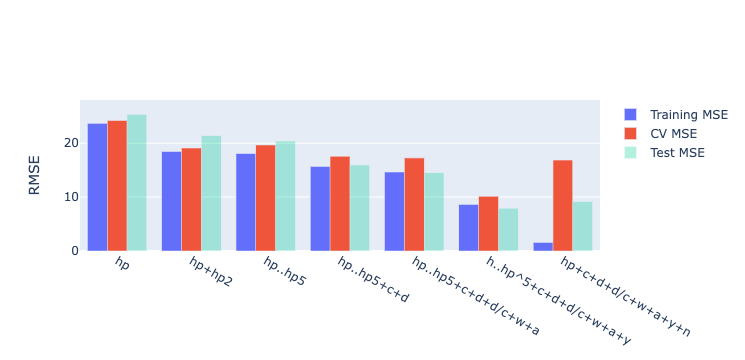

In [619]:
fig = compare_models(models)
fig.update_yaxes(range=[0,28], title="RMSE")

**Overfitting!**.  We substantially reduced the training error but actually made the generalization error worse!

## Finalizing the Model:

In [621]:
best_model = clone(models['h..hp^5+c+d+d/c+w+a+y'])

In [623]:
best_model.fit(X_train, Y_train);

In [625]:
mse(best_model.predict(X_test), Y_test)

7.947190387711921

## Limitations of Using Cross Validation:
Using cross-validation to manage model complexity has a couple of critical limitations: typically it requires the complexity to vary discretely; and there may not be a natural way to order the models. Rather than changing the dimensions of a sequence of models, we can fit a large model and apply constraints on the size of the coefficients. This notion is called regularization and is the topic of the next section.